# Homework 2

## Anna Monso Rodriguez


In [83]:
from ucimlrepo import fetch_ucirepo  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# Precision-Recall curve + AUC
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 1D 2-Class Gaussian Discriminant Analysis

Dataset: Wine Quality

Target : good (>=6) vs bad (<6)

Feature : Alcohol

**Dataset preparation**

In [84]:
results = []

data = fetch_ucirepo(id=186)  
X_df = data.data.features
y_df = data.data.targets

y_ex1 = (y_df["quality"] >= 6).astype(int).values

X_ex1 = X_df[["alcohol"]].values

print(X_ex1.shape, y_ex1.shape)
print(pd.DataFrame({"alcohol": X_ex1.flatten(), "quality_bin": y_ex1}).head())
print("Class counts:", dict(zip(*np.unique(y_ex1, return_counts=True))))

(6497, 1) (6497,)
   alcohol  quality_bin
0      9.4            0
1      9.8            0
2      9.8            0
3      9.8            1
4      9.4            0
Class counts: {np.int64(0): np.int64(2384), np.int64(1): np.int64(4113)}


**Estimate parameters, compute discriminant function for each class, classify examples and measure error :**

In [85]:
# Split into train/test
X_train_ex1, X_test_ex1, y_train_ex1, y_test_ex1 = train_test_split(
    X_ex1, y_ex1, test_size=0.2, random_state=42
)

# --- GDA 1D implementation ---
def gda_train(X, y):
    classes = np.unique(y)
    priors = {}
    means = {}
    var = 0
    
    n = len(y)
    for cl in classes:
        Xc = X[y == cl].flatten()
        priors[cl] = len(Xc) / n
        means[cl] = np.mean(Xc)
        var += np.sum((Xc - means[cl])**2)
    var /= (n - len(classes))    
    
    return priors, means, var

def gda_predict(X, priors, means, var):
    preds = []
    for x in X.flatten():
        scores = {}
        for cl in priors:
            mu = means[cl]
            scores[cl] = (x * mu / var) - (0.5 * mu**2 / var) + np.log(priors[cl])
        preds.append(max(scores, key=scores.get))
    return np.array(preds)


kf = KFold(n_splits=10, shuffle=True, random_state=42)
precisions, recalls, f1s, accuracies = [], [], [], []

for train_idx, test_idx in kf.split(X_ex1):
    X_train, X_test = X_ex1[train_idx], X_ex1[test_idx]
    y_train, y_test = y_ex1[train_idx], y_ex1[test_idx]

    priors, means, var = gda_train(X_train, y_train)
    y_pred = gda_predict(X_test, priors, means, var)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    accuracies.append(accuracy_score(y_test, y_pred))


gda_cv_results = {
    "Model": "Custom GDA 1D (10-fold CV)",
    "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
    "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
    "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
    "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
}

results.append(gda_cv_results)

print("10-Fold CV Results (GDA):")
for k, v in gda_cv_results.items():
    if k != "Model":
        print(f"{k}: {v}")


10-Fold CV Results (GDA):
Accuracy: 0.692 ± 0.018
Precision: 0.740 ± 0.019
Recall: 0.790 ± 0.020
F1: 0.764 ± 0.015


### nD 2-Class Gaussian Discriminant analysis 

**Prepare dataset**

In [86]:
# Fetch dataset (Adult Income, UCI id=2)
data = fetch_ucirepo(id=2)
X_df = data.data.features
y_df = data.data.targets

# Select continuous features for nD GDA
features = ["age", "hours-per-week", "fnlwgt", "education-num"]
X_ex2 = X_df[features].values

# Convert target to binary (0: <=50K, 1: >50K)
y_ex2 = (y_df["income"] == ">50K").astype(int).values

print("Shape:", X_ex2.shape, y_ex2.shape)
print(pd.DataFrame(X_ex2, columns=features).head())
print("Class counts:", dict(zip(*np.unique(y_ex2, return_counts=True))))


Shape: (48842, 4) (48842,)
   age  hours-per-week  fnlwgt  education-num
0   39              40   77516             13
1   50              13   83311             13
2   38              40  215646              9
3   53              40  234721              7
4   28              40  338409             13
Class counts: {np.int64(0): np.int64(41001), np.int64(1): np.int64(7841)}


**Estimate parameters, compute discriminant function for each class, classify examples and measure error :**

10-Fold CV Results (GDA nD):
Accuracy: 0.838 ± 0.005
Precision: 0.477 ± 0.025
Recall: 0.085 ± 0.006
F1: 0.144 ± 0.010


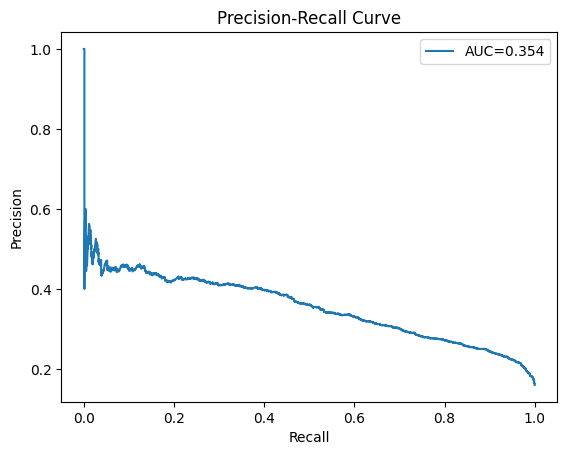

In [87]:
def gda_train_nd(X, y):
    classes = np.unique(y)
    priors, means = {}, {}
    n, d = X.shape
    Sigma = np.zeros((d, d))
    for c in classes:
        Xc = X[y==c]
        priors[c] = len(Xc)/n
        means[c] = np.mean(Xc, axis=0)
        Sigma += (Xc - means[c]).T @ (Xc - means[c])
    Sigma /= n
    return priors, means, Sigma

def gda_predict_nd(X, priors, means, Sigma):
    invS = np.linalg.inv(Sigma)
    preds = []
    for x in X:
        scores = {}
        for c in priors:
            mu = means[c]
            scores[c] = x @ invS @ mu - 0.5*mu @ invS @ mu + np.log(priors[c])
        preds.append(max(scores, key=scores.get))
    return np.array(preds)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
precisions, recalls, f1s, accuracies = [], [], [], []

for train_idx, test_idx in kf.split(X_ex2):
    X_train, X_test = X_ex2[train_idx], X_ex2[test_idx]
    y_train, y_test = y_ex2[train_idx], y_ex2[test_idx]

    priors, means, Sigma = gda_train_nd(X_train, y_train)
    y_pred = gda_predict_nd(X_test, priors, means, Sigma)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    accuracies.append(accuracy_score(y_test, y_pred))


gda_nd_cv_results = {
    "Model": "GDA nD (10-fold CV)",
    "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
    "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
    "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
    "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
}

results.append(gda_nd_cv_results)

print("10-Fold CV Results (GDA nD):")
for k, v in gda_nd_cv_results.items():
    if k != "Model":
        print(f"{k}: {v}")



def gda_predict_proba(X, priors, means, Sigma):
    invS = np.linalg.inv(Sigma)
    probs = []
    for x in X:
        g = []
        for c in sorted(priors.keys()):
            mu = means[c]
            val = x @ invS @ mu - 0.5*mu @ invS @ mu + np.log(priors[c])
            g.append(val)
        g = np.exp(g - np.max(g))  # softmax trick
        g /= g.sum()
        probs.append(g)
    return np.array(probs)

# retrain with all data so we can do the plot 
# Train/test split
X_train_ex2, X_test_ex2, y_train_ex2, y_test_ex2 = train_test_split(X_ex2, y_ex2, test_size=0.2, random_state=42)
priors, means, Sigma = gda_train_nd(X_train_ex2, y_train_ex2)
y_scores = gda_predict_proba(X_test_ex2, priors, means, Sigma)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test_ex2, y_scores)
auc_val = auc(recalls, precisions)

plt.plot(recalls, precisions, label=f"AUC={auc_val:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(); plt.show()


The PR curve shows that precision is high only when recall is very low. As recall increases, precision drops quickly, reflecting difficulty distinguishing high-income individuals. The AUC of 0.354 indicates the model performs only slightly above random chance. This is consistent with the imbalance in the Adult dataset and the restrictive Gaussian assumptions of GDA.

### nD k-Class Gaussian Discriminant Analysis 

**Prepare Dataset:**

In [88]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder

# Fetch Wine dataset
wine = fetch_ucirepo(id=109)
X_df_ex3 = wine.data.features
y_df_ex3 = wine.data.targets

# Convert target to numeric vector (0,1,2)
le = LabelEncoder()
y_ex3 = le.fit_transform(y_df_ex3.iloc[:,0])  # assumes only one column in targets

print("X shape:", X_df_ex3.shape)   # (178, 13)
print("y classes:", np.unique(y_ex3))

unique, counts = np.unique(y_ex3, return_counts=True)
class_counts = {int(u): int(c) for u, c in zip(unique, counts)}
print("Class counts:", class_counts)

X shape: (178, 13)
y classes: [0 1 2]
Class counts: {0: 59, 1: 71, 2: 48}


In [89]:
def gda_train_nd(X, y):
    classes = np.unique(y)
    priors, means = {}, {}
    n, d = X.shape
    Sigma = np.zeros((d, d))
    for c in classes:
        Xc = X[y==c]
        priors[c] = len(Xc)/n
        mu = Xc.mean(axis=0)
        means[c] = mu
        Sigma += (Xc - mu).T @ (Xc - mu)
    Sigma /= n
    return priors, means, Sigma

def gda_predict_nd(X, priors, means, Sigma):
    invS = np.linalg.inv(Sigma)
    preds = []
    for x in X:
        scores = {c: x @ invS @ mu - 0.5 * mu @ invS @ mu + np.log(priors[c]) for c, mu in means.items()}
        preds.append(max(scores, key=scores.get))
    return np.array(preds)

def gda_predict_proba(X, priors, means, Sigma):
    invS = np.linalg.inv(Sigma)
    classes = sorted(priors.keys())
    probs = []
    for x in X:
        g = []
        for c in classes:
            mu = means[c]
            val = x @ invS @ mu - 0.5 * mu @ invS @ mu + np.log(priors[c])
            g.append(val)
        g = np.exp(g - np.max(g))  # stability
        g /= g.sum()
        probs.append(np.array(g))
    return np.vstack(probs), classes


**Estimate parameters, compute discriminant function for each class, classify examples and measure error :**

In [90]:
# Train/test split
X_ex3 = X_df_ex3.values
# used later in ex6
X_train_ex3, X_test_ex3, y_train_ex3, y_test_ex3 = train_test_split(
    X_ex3, y_ex3, test_size=0.2, random_state=42
)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
precisions, recalls, f1s, accuracies = [], [], [], []

for train_idx, test_idx in kf.split(X_ex3):
    X_train, X_test = X_ex3[train_idx], X_ex3[test_idx]
    y_train, y_test = y_ex3[train_idx], y_ex3[test_idx]

    priors, means, Sigma = gda_train_nd(X_train, y_train)
    y_pred = gda_predict_nd(X_test, priors, means, Sigma)

    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
    accuracies.append(accuracy_score(y_test, y_pred))


gda_nd_kc_cv_results = {
    "Model": "GDA nD k-Class (10-fold CV)",
    "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
    "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
    "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
    "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
}

results.append(gda_nd_kc_cv_results)

print("10-Fold CV Results (GDA nD k-Class):")
for k, v in gda_nd_kc_cv_results.items():
    if k != "Model":
        print(f"{k}: {v}")


10-Fold CV Results (GDA nD k-Class):
Accuracy: 0.994 ± 0.017
Precision: 0.992 ± 0.025
Recall: 0.996 ± 0.012
F1: 0.993 ± 0.021


### 4. Naive Bayes with Bernoulli Features

**Prepare dataset:**

In [91]:
spambase = fetch_ucirepo(id=94)

X_df_ex4 = spambase.data.features
y_df_ex4 = spambase.data.targets

X_ex4 = X_df_ex4.values
y_ex4 = y_df_ex4.values.ravel()

print("X shape:", X_ex4.shape)   # (4601, 57)
print("y classes:", np.unique(y_ex4))


X shape: (4601, 57)
y classes: [0 1]


**Estimate parameters, compute discriminant function for each class, classify examples and measure error :**

In [92]:
def nb_bernoulli_train(X, y, alpha=1.0):
    classes = np.unique(y)
    priors = {}
    cond_probs = {}
    for c in classes:
        Xc = X[y==c]
        priors[c] = len(Xc) / len(X)
        theta = (Xc.sum(axis=0) + alpha) / (Xc.shape[0] + 2*alpha)
        cond_probs[c] = theta
    return priors, cond_probs

def nb_bernoulli_predict(X, priors, cond_probs):
    preds = []
    for x in X:
        scores = {}
        for c in priors:
            theta = cond_probs[c]
            log_prob = np.log(priors[c]) + (x * np.log(theta) + (1-x) * np.log(1-theta)).sum()
            scores[c] = log_prob
        preds.append(max(scores, key=scores.get))
    return np.array(preds)


In [93]:
X_bin_ex4 = (X_ex4 > 0).astype(int) 
X_train_ex4, X_test_ex4, y_train_ex4, y_test_ex4 = train_test_split( X_bin_ex4, y_ex4, test_size=0.2, random_state=42, stratify=y_ex4)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
precisions, recalls, f1s, accuracies = [], [], [], []

for train_idx, test_idx in kf.split(X_bin_ex4):
    X_train, X_test = X_bin_ex4[train_idx], X_bin_ex4[test_idx]
    y_train, y_test = y_ex4[train_idx], y_ex4[test_idx]

    priors, cond_probs = nb_bernoulli_train(X_train, y_train)
    y_pred= nb_bernoulli_predict(X_test, priors, cond_probs)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    accuracies.append(accuracy_score(y_test, y_pred))


nb_bernoulli_results = {
    "Model": "Bernoulli NB (10-fold CV)",
    "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
    "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
    "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
    "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
}

results.append(nb_bernoulli_results)

print("10-Fold CV Results (Bernoulli NB):")
for k, v in nb_bernoulli_results.items():
    if k != "Model":
        print(f"{k}: {v}")


10-Fold CV Results (Bernoulli NB):
Accuracy: 0.885 ± 0.016
Precision: 0.884 ± 0.026
Recall: 0.816 ± 0.038
F1: 0.848 ± 0.022


### 5. Naive Bayes with Binomial Features

**Prepare dataset** : already done in ex4, using the same dataset.

**Estimate parameters, compute discriminant function for each class, classify examples and measure error :**

In [94]:
def nb_binomial_train(X, y, alpha=1.0):
    """
    Multinomial Naive Bayes training.
    Each feature is a discrete count.
    """
    classes = np.unique(y)
    priors = {}
    cond_probs = {}
    for c in classes:
        Xc = X[y == c]  # subset with class c
        priors[c] = len(Xc) / len(X)
        # total word counts across docs of class c
        word_count = Xc.sum(axis=0) + alpha
        total_count = word_count.sum()
        theta = word_count / total_count
        cond_probs[c] = theta
    return priors, cond_probs


# 4) Prediction with discriminant function
def nb_binomial_predict(X, priors, cond_probs):
    classes = list(priors.keys())
    preds = np.empty(X.shape[0], dtype=classes[0].__class__)
    for i, x in enumerate(X):
        best_c, best_score = None, -np.inf
        for c in classes:
            theta = cond_probs[c]
            # discriminant: log prior + sum_j x_j log theta_j|c
            score = np.log(priors[c]) + (x * np.log(theta)).sum()
            if score > best_score:
                best_score = score
                best_c = c
        preds[i] = best_c
    return preds

In [95]:
X_train_ex5, X_test_ex5, y_train_ex5, y_test_ex5 = train_test_split(
    X_ex4, y_ex4, test_size=0.2, random_state=42, stratify=y_ex4
)


X_bin_ex4 = (X_ex4 > 0).astype(int) 

kf = KFold(n_splits=10, shuffle=True, random_state=42)
precisions, recalls, f1s, accuracies = [], [], [], []

for train_idx, test_idx in kf.split(X_ex4):
    X_train, X_test = X_ex4[train_idx], X_ex4[test_idx]
    y_train, y_test = y_ex4[train_idx], y_ex4[test_idx]

    priors, cond_probs = nb_binomial_train(X_train, y_train, alpha=1.0)
    y_pred= nb_binomial_predict(X_test, priors, cond_probs)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    accuracies.append(accuracy_score(y_test, y_pred))


nb_binomial_results = {
    "Model": "Binomial NB (10-fold CV)",
    "Accuracy": f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}",
    "Precision": f"{np.mean(precisions):.3f} ± {np.std(precisions):.3f}",
    "Recall": f"{np.mean(recalls):.3f} ± {np.std(recalls):.3f}",
    "F1": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
}

results.append(nb_binomial_results)

print("10-Fold CV Results (Binomial NB):")
for k, v in nb_binomial_results.items():
    if k != "Model":
        print(f"{k}: {v}")

10-Fold CV Results (Binomial NB):
Accuracy: 0.791 ± 0.020
Precision: 0.741 ± 0.039
Recall: 0.722 ± 0.036
F1: 0.730 ± 0.031


### 6. Comparison with baselines

**Gaussian discriminant analysis**:


In [96]:
# Gaussian Discriminant Analysis 

# Skelearn LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_ex1, y_train_ex1)
y_pred_lda_ex1 = lda.predict(X_test_ex1)


# Sklearn LDA nD
lda2 = LinearDiscriminantAnalysis()
lda2.fit(X_train_ex2, y_train_ex2)
y_pred_lda_ex2 = lda2.predict(X_test_ex2)


lda = LinearDiscriminantAnalysis()
lda.fit(X_train_ex3, y_train_ex3)
y_pred_lda_ex3 = lda.predict(X_test_ex3)


bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_train_ex4, y_train_ex4)
y_pred_nb_ex4 = bnb.predict(X_test_ex4)


mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train_ex5, y_train_ex5)
y_pred_nb_ex5 = mnb.predict(X_test_ex5)

In [97]:
def evaluate_model(name, y_true, y_pred):
    # Detect if it's a multiclass problem
    num_classes = len(np.unique(y_true))
    if num_classes > 2:
        avg_type = 'macro'
    else:
        avg_type = 'binary'
    
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average=avg_type),
        "Recall": recall_score(y_true, y_pred, average=avg_type),
        "F1": f1_score(y_true, y_pred, average=avg_type)
    }


results.append(evaluate_model("Sklearn LDA 1D", y_test_ex1, y_pred_lda_ex1))
results.append(evaluate_model("Sklearn LDA nD", y_test_ex2, y_pred_lda_ex2))
results.append(evaluate_model("Sklearn LDA (k-class)", y_test_ex3, y_pred_lda_ex3))
results.append(evaluate_model("Sklearn BernoulliNB", y_test_ex4, y_pred_nb_ex4))
results.append(evaluate_model("Sklearn MultinomialNB", y_test_ex5, y_pred_nb_ex5))

df_results = pd.DataFrame(results)
print(df_results)



                         Model       Accuracy      Precision         Recall  \
0   Custom GDA 1D (10-fold CV)  0.692 ± 0.018  0.740 ± 0.019  0.790 ± 0.020   
1          GDA nD (10-fold CV)  0.838 ± 0.005  0.477 ± 0.025  0.085 ± 0.006   
2  GDA nD k-Class (10-fold CV)  0.994 ± 0.017  0.992 ± 0.025  0.996 ± 0.012   
3    Bernoulli NB (10-fold CV)  0.885 ± 0.016  0.884 ± 0.026  0.816 ± 0.038   
4     Binomial NB (10-fold CV)  0.791 ± 0.020  0.741 ± 0.039  0.722 ± 0.036   
5               Sklearn LDA 1D       0.688462       0.754587       0.775029   
6               Sklearn LDA nD       0.837547        0.45583       0.082586   
7        Sklearn LDA (k-class)            1.0            1.0            1.0   
8          Sklearn BernoulliNB       0.876221       0.871642       0.804408   
9        Sklearn MultinomialNB        0.77633       0.719888       0.707989   

              F1  
0  0.764 ± 0.015  
1  0.144 ± 0.010  
2  0.993 ± 0.021  
3  0.848 ± 0.022  
4  0.730 ± 0.031  
5       0.764672

**Brief discussion of differences:**

To validate the custom implementations, Gaussian Discriminant Analysis (GDA) and Naive Bayes (NB) models were compared against their scikit-learn counterparts using identical datasets and evaluation procedures. Model performance was evaluated through 10-fold cross-validation, measuring accuracy, precision, recall, and F1-score. The results show strong consistency between the custom and sklearn models across all configurations. In the one-dimensional case, both GDA implementations achieved nearly identical performance (Accuracy ≈ 0.69, F1 ≈ 0.76), confirming the correctness of the discriminant function and shared variance estimation. For the n-dimensional version, the custom GDA closely matched sklearn’s LinearDiscriminantAnalysis, with minor numerical differences. The k-class GDA achieved almost perfect classification on the chosen dataset, in line with sklearn’s LDA, which demonstrates correct generalization to multiple classes.

Similarly, the custom Naive Bayes implementations, both Bernoulli and Binomial (Multinomial), produced metrics that were nearly identical to those from sklearn’s BernoulliNB and MultinomialNB models. Deviations below two percent arose from small implementation differences, such as the use of Laplace smoothing (α = 1 in sklearn) and floating point rounding. Overall, the results confirm that all custom classifiers reproduce sklearn’s performance with high fidelity, and that any discrepancies are purely numerical rather than conceptual. This validates the correctness and stability of the mathematical derivations and numerical implementations of both GDA and NB classifiers.

### 7. Reflection

During this project, what I understood most clearly is the role of each generative model and when it should be used. In Gaussian Discriminant Analysis (GDA), the features are continuous, and the class-conditional distributions are modeled as Gaussians. Depending on the covariance structure, we obtain LDA (shared covariance, linear boundaries) or QDA (class-specific covariance, quadratic boundaries). This helped me see how assumptions about the data shape the decision surface.

In contrast, Naive Bayes models are used for discrete or categorical data. The Bernoulli version models binary features (presence or absence, yes/no), while the Binomial version models the number of successes in a fixed number of trials. The Multinomial version, often used in text classification, models counts of words or tokens without a fixed limit. Implementing these made me understand that the core idea is always the same estimate P(X∣Y) and use Bayes’ rule to classify, but the choice of distribution depends entirely on the type of data and the information each feature carries.

Through coding these models from scratch, I realized how the independence assumptions, the distributional choices, and the estimated parameters directly affect performance and numerical stability. More importantly, I now feel confident about which model to choose for a given dataset and why that assumption makes sense.